In [10]:
import numpy as np
import argparse
import os
import sys
import torch
import torch.fft as F
from importlib import reload
from torch.nn.functional import relu
import torch.nn as nn
import torch.nn.functional as Func
import torch.optim as optim
import utils
from matplotlib import pyplot as plt
import random
import copy

from utils import kplot,mask_naiveRand,mask_filter, get_x_f_from_yfull, mnet_wrapper
from utils import mask_complete, mask_makebinary,raw_normalize, visualization
from mnet import MNet
from mask_backward_new import mask_backward, mask_eval


sys.path.insert(0,'/home/huangz78/mri/unet/')
from unet_model import UNet

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [9]:
# load a mnet
mnet = MNet(out_size=320-24)
checkpoint = torch.load('/home/huangz78/checkpoints/mnet.pth')
mnet.load_state_dict(checkpoint['model_state_dict'])
print('MNet loaded successfully from: ' + '/home/huangz78/checkpoints/mnet.pth')

MNet loaded successfully from: /home/huangz78/checkpoints/mnet.pth


In [3]:
# load a unet for maskbackward
UNET =  UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
checkpoint = torch.load('/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth')
UNET.load_state_dict(checkpoint['model_state_dict'])
print('Unet loaded successfully from : ' + '/home/huangz78/checkpoints/unet_'+ str(UNET.n_channels) +'.pth' )

Unet loaded successfully from : /home/huangz78/checkpoints/unet_1.pth


In [4]:
train_dir = '/home/huangz78/data/traindata_x.npz'
# train_sub = np.load(train_dir)['x']
train_full = np.load(train_dir)['xfull']

In [5]:
fullmask = torch.fft.fftshift(torch.tensor(np.load(train_dir)['mask'])) # roll the input mask

In [6]:
test_dir = '/home/huangz78/data/testdata_x.npz'
testimg  = torch.tensor(np.load(test_dir)['x']) 
print(testimg.shape)
# test_sub  = test_sub[0:10,:,:]
# test_full = torch.tensor(np.load(test_dir)['xfull']) 
mask_greedy = np.load('/home/huangz78/data/data_gt_greedymask.npz')
mask_greedy = mask_greedy['mask'].T # this greedy mask is rolled
print(mask_greedy.shape)

torch.Size([199, 320, 320])
(199, 320)


In [ ]:
# select an image whose greedy mask we have
# test_dir  = '/home/huangz78/data/data_gt.npz'
# test_full = torch.tensor( np.transpose(np.load(test_dir)['imgdata'],axes=(2,0,1)) )

In [8]:
def alternating_update_with_unetRecon(mnet,unet,trainfulls,testimg,mask_init,mask_init_full=True,\
                                      maxIter_mb=50,evalmode='unet',alpha=2.8*1e-5,c=0.05, Lambda=1e-4,\
                                      lr_mb=1e-4,lr_mn=1e-4,maxRep=5,epoch=1,\
                                      corefreq=24,budget=24,plot=False,verbose=False,mask_greedy=None,\
                                      change_initmask=True,validate_every=10,dtyp=torch.float,\
                                      save_cp=False):
    '''
    alpha: magnitude of l1 penalty for high-frequency mask
    mnet : the input mnet needs to coordinate exactly with corefreq
    '''
    if mask_init_full:
        fullmask = torch.tensor(mask_init).clone()
        highmask = mask_filter(fullmask,base=corefreq,roll=True)
    else:
        fullmask = mask_complete(torch.tensor(mask_init),trainfulls.shape[1],rolled=True,dtyp=dtyp)
        highmask = torch.tensor(mask_init).clone()
    DTyp = torch.cfloat if dtyp==torch.float else torch.cdouble
    dir_checkpoint = '/home/huangz78/checkpoints/'
    criterion_mnet = nn.BCEWithLogitsLoss()
    optimizer_m = optim.RMSprop(mnet.parameters(), lr=lr_mn, weight_decay=0, momentum=0)
    # optimizer_u = ......
    
    unet_eval = UNet(n_channels=1,n_classes=1,bilinear=True,skip=False)
    unet_eval = copy.deepcopy(unet)
    unet_eval.eval()
    # training loop
    global_step = 0

    randqual = []; mnetqual = []
    randspar = []; mnetspar = []
    if mask_greedy is not None:
        greedyqual = []
        greedyspar = np.sum(mask_greedy[0,:])/trainfulls.shape[1]
    else:
        greedyqual = None; greedyspar = None
    epoch_count = 0
    while epoch_count<epoch:
        for xstar in trainfulls:
            xstar = torch.tensor(xstar,dtype=dtyp)
            yfull = torch.fft.fftshift(F.fftn(xstar,dim=(0,1),norm='ortho')) # y is ROLLED!
            lowfreqmask,_,_ = mask_naiveRand(xstar.shape[0],fix=corefreq,other=0,roll=True)
            x_lf            = get_x_f_from_yfull(lowfreqmask,yfull)
            ########################################  
            ## (1) mask_backward
            ########################################        
            if change_initmask and global_step>0: # option 2: highmask = mask_pred from step (2)
                highmask = mnet(x_lf.view(1,1,xstar.shape[0],xstar.shape[1])).view(-1)
            highmask_refined,unet = mask_backward(highmask,xstar_batch,unet=unet, mnet=mnet,\
                              beta=1.,alpha=alpha,c=c,\
                              maxIter=maxIter_mb,seed=0,break_limit=maxIter_mb*3//5,\
                              lr=lr_mb,mode='UNET',budget=budget,normalize=True,\
                              verbose=verbose,dtyp=torch.float)        
            ########################################  
            ## (2) update mnet
            ########################################        
            mnet.train()
            unet.eval()
            rep = 0
            while rep < maxRep:
                mask_pred  = mnet(x_lf.view(1,1,xstar.shape[0],xstar.shape[1]))
    #             mask_pred_full = mask_complete(mask_pred.view(-1),xstar.shape[0],rolled=True,dtyp=dtyp) # ??
    #             x_lf_new   = get_x_f_from_yfull(mask_pred_full,yfull).view(1,1,xstar.shape[0],xstar.shape[1]) # ??
    #             x_unet     = unet(x_lf_new) # ??
                train_loss = criterion_mnet(mask_pred,highmask_refined.view(mask_pred.shape))
                optimizer_m.zero_grad()
                # optimizer step wrt unet parameters ?
                train_loss.backward()
                optimizer_m.step()
                rep += 1
            mnet.eval()             
            ########################################  
            ## (3) check mnet performance: does it beat random sampling?
            ########################################
            if (global_step%validate_every==0) or (global_step==trainfulls.shape[0]-1):
                randqual_tmp = 0; mnetqual_tmp = 0; greedyqual_tmp = 0
                randspar_tmp = 0; mnetspar_tmp = 0
                imgind = 0
                for img in testimg:
                    x_test_lf     = img
                    mask_test     = mnet_wrapper(mnet,x_test_lf,budget,img.shape,dtyp=dtyp)
                    mask_rand,_,_ = mask_naiveRand(img.shape[0],fix=corefreq,other=mask_test.sum().item()-corefreq,roll=True)              
                    
                    randqual_img  = mask_eval(mask_rand,img,UNET=unet_eval)
                    mnetqual_img  = mask_eval(mask_test,img,UNET=unet) # UNET = unet_eval               
                    randqual_tmp += randqual_img
                    mnetqual_tmp += mnetqual_img                
                    if verbose:
                        print('Quality of random mask : ', randqual_img) 
                        print('Quality of mnet   mask : ', mnetqual_img)

                    ### compute sampling ratio of generated masks
                    randspar_img  = mask_rand.sum().item()/img.shape[0]
                    mnetspar_img  = mask_test.sum().item()/img.shape[0]
                    randspar_tmp += randspar_img
                    mnetspar_tmp += mnetspar_img
                    if mask_greedy is not None:
                        greedyqual_img = mask_eval(mask_greedy[imgind,:],img,mode='sigpy',Lambda=Lambda) # UNET=unet_eval
                        greedyqual_tmp += greedyqual_img
                        if verbose:
                            print('Quality of greedy mask : ', greedyqual_img)
                            print(f'sparsity of random mask: {randspar_img},mnet mask: {mnetspar_img}, \
                                    greedy mask: {greedyspar}\n')
                    else:
                        if verbose:
                            print(f'sparsity of random mask: {randspar_img},mnet mask: {mnetspar_img}\n')
                    imgind += 1
                randqual.append( randqual_tmp/testimg.shape[0] )
                mnetqual.append( mnetqual_tmp/testimg.shape[0] )
                if mask_greedy is not None:
                    greedyqual.append( greedyqual_tmp/testimg.shape[0] )
                randspar.append( randspar_tmp/testimg.shape[0] )
                mnetspar.append( mnetspar_tmp/testimg.shape[0] )
                if plot:
                    try:
                        visualization(randqual,mnetqual,greedyqual=greedyqual,\
                                 randspar=randspar,mnetspar=mnetspar,greedyspar=greedyspar*np.ones(len(greedyqual)))
                    except Exception:
                        visualization(randqual,mnetqual,randspar=randspar,mnetspar=mnetspar)
                if save_cp:
                    torch.save({'model_state_dict': mnet.state_dict()}, dir_checkpoint + 'mnet_split_trained.pth')
                    torch.save({'model_state_dict': unet.state_dict()}, dir_checkpoint + 'unet_split_trained.pth')
                    print(f'\t Checkpoint saved at epoch {epoch_count}, iter {global_step + 1}!')
                    filepath = '/home/huangz78/checkpoints/alternating_update_error_track.npz'
                    np.savez(filepath,randqual=randqual,mnetqual=mnetqual,greedyqual=greedyqual,randspar=randspar,mnetspar=mnetspar)
            global_step += 1
        epoch_count+= 1
    # return mnet, unet

/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/home/huangz78/mri/mask_backward_new.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xstar = torch.tensor(xstar,dtype=dtyp); highmask = torch.tensor(highmask,dtype=dtyp)
/home/huangz78/mri/mask_backward_new.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fullmask = torch.tensor( mask_complete(M_high,imgHeg,dtyp=dtyp) )
/opt/anaconda/envs/pyenv/lib/python3.7/site-packages/torch/autog

No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.515460908412933


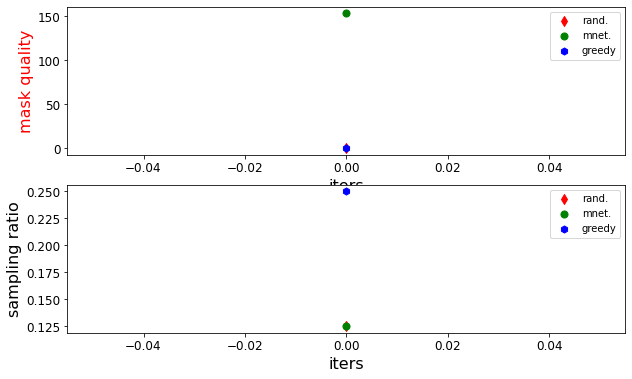

/home/huangz78/mri/mask_backward_new.py:120: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  xstar = torch.tensor(xstar,dtype=dtyp); highmask = torch.tensor(highmask,dtype=dtyp)
/home/huangz78/mri/mask_backward_new.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  fullmask = torch.tensor( mask_complete(M_high,imgHeg,dtyp=dtyp) )



return at Iter:  10
loss of returned mask:  10.790970176458359
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.562146991491318
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  10.96767708659172

return at Iter:  10
loss of returned mask:  10.806838423013687
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.17037609219551
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.066911369562149
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  10.643615573644638
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.112555861473083
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  10.677412152290344
No cha

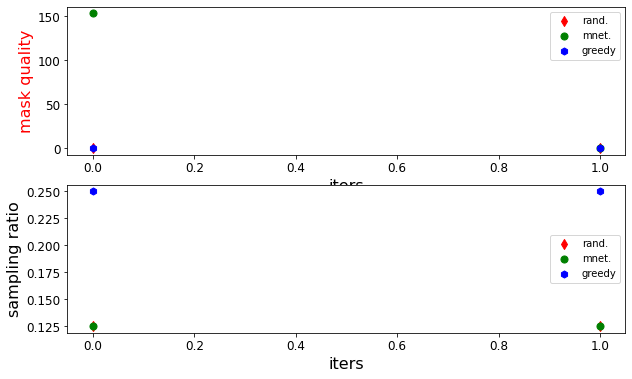

No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  10.47825813293457
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.294886469841003
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  12.260805815458298
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  12.681548297405243
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.523056030273438
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  10.73717549443245
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.199910193681717
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  10.025015473365784
No change 

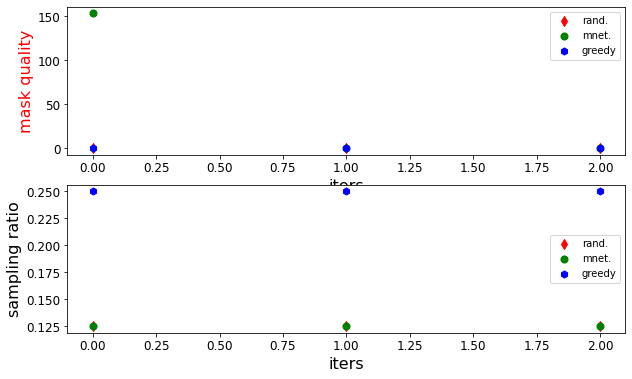

No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  8.592170476913452
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  7.227566838264465
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  7.786576449871063
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  12.409447133541107
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  12.316988408565521
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  13.422651588916779
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  12.537294626235962
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of retu

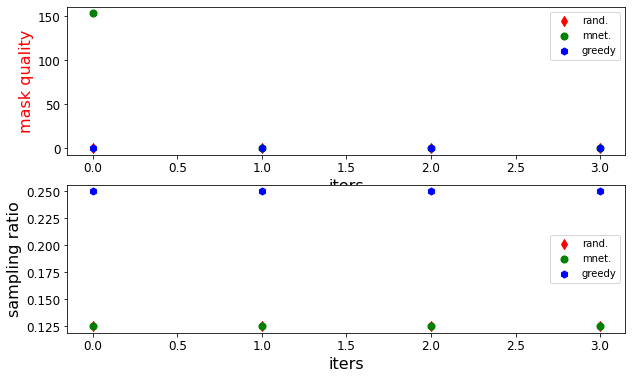

No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  10.203749686479568
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  9.98632088303566
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  9.969745576381683
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  9.147410839796066
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  9.359827637672424
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  11.336513608694077
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  12.110089510679245
No further decrease in loss after 6 consecutive iters, ending itera

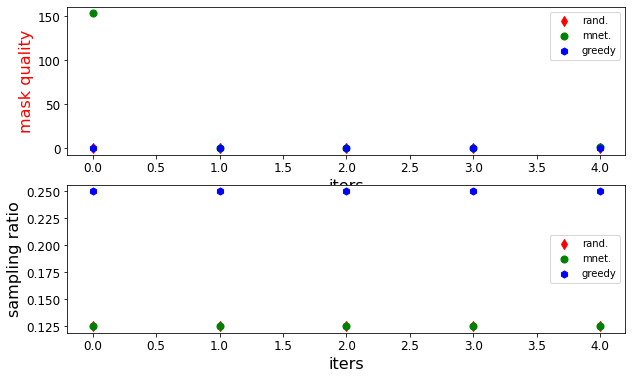

No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  12.659408152103424
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.79670649766922
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  14.839422702789307
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  12.860450148582458
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  13.25305849313736
No change in row selections after 7 iters, ending iteration~

return at Iter:  6
loss of returned mask:  13.83456140756607
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.04733157157898
No further decrease in loss after 6 consecutive iters, ending iter

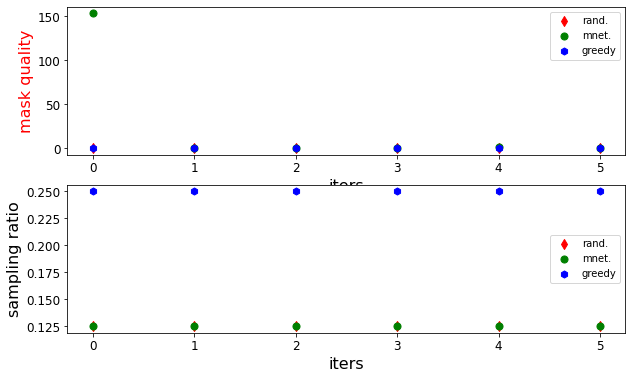

No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  12.272898107767105
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.248157501220703
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  12.891559302806854
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  14.234861731529236
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.498452305793762
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  14.010769128799438
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.232308626174927
No further decrease in loss after 

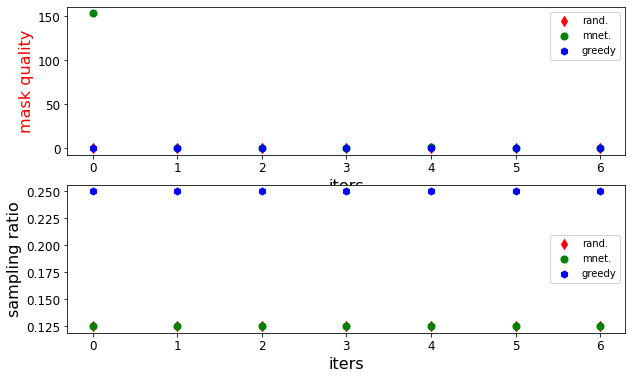

No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  8.062713593244553
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  8.752787858247757
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  9.27630141377449
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  8.186257630586624
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  7.799900323152542
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  7.703039050102234
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  7.5073279440402985
No further decrease in loss after 6 conse

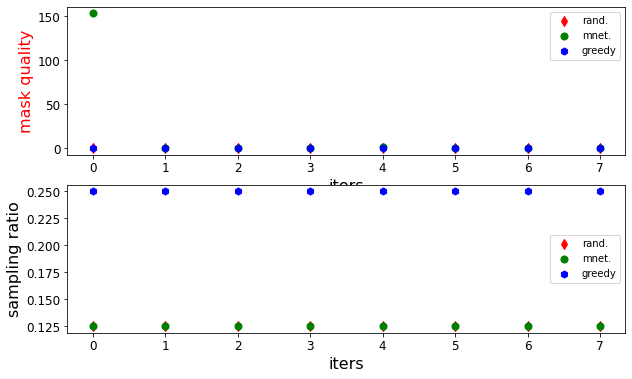

No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  14.923647046089172
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.65455836057663
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.559029996395111
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.60255777835846
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.999685645103455
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  14.17032778263092
No further decrease in loss after 6 consecutive iters, ending iterations~ 

return at Iter:  6
loss of returned mask:  13.882316648960114
No further decrease in loss after 6 c

KeyboardInterrupt: 

In [9]:
alternating_update_with_unetRecon(mnet,UNET,train_full,testimg[0:20,:,:],fullmask,\
                                  alpha=3e-4,c=1e-2,Lambda=1e-4,\
                                  lr_mb=1e-3,lr_mn=1e-4,\
                                  maxIter_mb=10,maxRep=2,\
                                  corefreq=24,budget=16,\
                                  mask_greedy=mask_greedy,change_initmask=True,\
                                  verbose=False,plot=True,validate_every=50,save_cp=True)

In [ ]:
reload(utils)
import mask_backward_new
reload(mask_backward_new)
from mask_backward_new import mask_backward
from utils import raw_normalize, visualization